In [ ]:
from google.colab import files

# Upload a zip file containing data folders
uploaded = files.upload()


Saving Data.zip to Data.zip


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from numpy import exp
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2


In [ ]:
import zipfile
# Specify the name of the uploaded zip file
zip_filename = "Data.zip"

# Extract the contents to a specific directory (e.g., /content/data)
extract_path = "data/Data/Data/Data/Data/Data/Data/Data/Data/Data/Data/Data/Data/Data"
train_folder = os.path.join(extract_path, 'train')
test_folder = os.path.join(extract_path, 'test')

# Unzip the file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
# Function to resize an image
def resize_image(image, new_size):
    image = image.resize(new_size, Image.ANTIALIAS)
    return image

# Define the new size for your images
new_image_size = (256, 256)  # Adjust to your desired dimensions

# Function to load and preprocess your data
def load_and_preprocess_data(data_type="train"):
    images = []
    masks = []

    # Paths
    image_path = os.path.join(extract_path, data_type, "image")
    mask_path = os.path.join(extract_path, data_type, "mask")

    for filename in sorted(os.listdir(image_path)):
        if not filename.endswith('.png'):  # Adjust if your images have a different extension
            continue

        # Read Image
        img = tf.io.read_file(os.path.join(image_path, filename))
        img = tf.image.decode_png(img, channels=1)

        # Resize the image
        img = tf.image.resize(img, new_image_size)  # Resize the image

        images.append(img)

        # Read corresponding mask
        mask = tf.io.read_file(os.path.join(mask_path, filename))
        mask = tf.image.decode_png(mask, channels=1)

        # Resize the mask (if needed)
        mask = tf.image.resize(mask, new_image_size)

        masks.append(mask)

    return tf.stack(images), tf.stack(masks)

# Load Training and Test Data and preprocess
train_images, train_masks = load_and_preprocess_data(data_type="train")
test_images, test_masks = load_and_preprocess_data(data_type="test")


In [ ]:
# Define the Intersection over Union (IoU) and Dice coefficient metrics
def DiceCoefficient(y_true, y_pred):
    smooth = 1e-5
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return K.mean(dice)

def IoU(y_true, y_pred):
    smooth = 1e-5
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return K.mean(iou)

def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - K.mean(dice)

def tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    smooth = 1e-5
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    true_positives = K.sum(y_true_f * y_pred_f)
    false_positives = K.sum((1 - y_true_f) * y_pred_f)
    false_negatives = K.sum(y_true_f * (1 - y_pred_f))
    tversky = (true_positives + smooth) / (true_positives + alpha * false_positives + beta * false_negatives + smooth)
    return 1 - K.mean(tversky)





In [ ]:
input_shape = (None, None, 1)  # Update according to your dataset
# U-Net architecture without batch normalization
def simple_unet_model_2_no_bn(input_shape, num_layers=2, base_filters=64):
    inputs = Input(input_shape)
    x = inputs
    down_layers = []
    for i in range(num_layers):
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        if i < num_layers - 1:
            x = Dropout(0.5)(x)
        down_layers.append(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    for i in range(num_layers - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, down_layers[i]])
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same',kernel_regularizer=l2(1e-4))(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

# Create the model without batch normalization
model_2_layers_no_bn = simple_unet_model_2_no_bn(input_shape, num_layers=2)
model_2_layers_no_bn.compile(optimizer=Adam(learning_rate=0.000001), loss=tversky_loss, metrics=[DiceCoefficient, IoU])
history = model_2_layers_no_bn.fit(train_images, train_masks, batch_size=16, epochs=4, validation_split=0.1)
layer_2_predicted_no_bn = model_2_layers_no_bn.predict(test_images)
dice_score_no_bn = DiceCoefficient(test_masks, layer_2_predicted_no_bn)
iou_score_no_bn = IoU(test_masks, layer_2_predicted_no_bn)

print(f"U Net Model with 2 Layers (No Batch Normalization) - Dice Score: {dice_score_no_bn}, IoU Score: {iou_score_no_bn}")


Epoch 1/4
5/5 [==============================] - 5s 616ms/step - loss: 0.7849 - DiceCoefficient: 0.2903 - IoU: 0.1700 - val_loss: 0.5417 - val_DiceCoefficient: 0.5268 - val_IoU: 0.3618
Epoch 2/4
5/5 [==============================] - 3s 544ms/step - loss: 0.7538 - DiceCoefficient: 0.3218 - IoU: 0.1920 - val_loss: 0.4736 - val_DiceCoefficient: 0.5953 - val_IoU: 0.4276
Epoch 3/4
5/5 [==============================] - 3s 559ms/step - loss: 0.7182 - DiceCoefficient: 0.3560 - IoU: 0.2168 - val_loss: 0.4018 - val_DiceCoefficient: 0.6678 - val_IoU: 0.5045
Epoch 4/4
1/1 [==============================] - 0s 164ms/step
U Net Model with 2 Layers (No Batch Normalization) - Dice Score: 0.7194300889968872, IoU Score: 0.5627126693725586


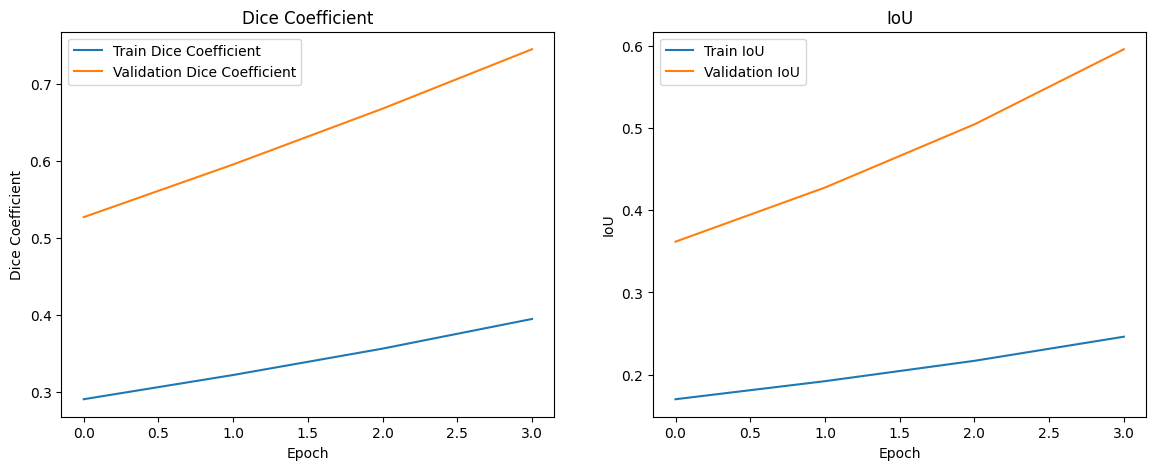

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation Dice coefficient and IoU
plt.figure(figsize=(14, 5))

# Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['DiceCoefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_DiceCoefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['IoU'], label='Train IoU')
plt.plot(history.history['val_IoU'], label='Validation IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()


In [ ]:
input_shape = (None, None, 1)  # Update according to your dataset
# U-Net architecture without batch normalization
def simple_unet_model_3_no_bn(input_shape, num_layers=3, base_filters=64):
    inputs = Input(input_shape)
    x = inputs
    down_layers = []
    for i in range(num_layers):
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        if i < num_layers - 1:
            x = Dropout(0.5)(x)
        down_layers.append(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    for i in range(num_layers - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, down_layers[i]])
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same',kernel_regularizer=l2(1e-4))(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

# Create the model without batch normalization
model_3_layers_no_bn = simple_unet_model_3_no_bn(input_shape, num_layers=2)
model_3_layers_no_bn.compile(optimizer=Adam(learning_rate=0.00000001), loss=tversky_loss, metrics=[DiceCoefficient, IoU])
history = model_3_layers_no_bn.fit(train_images, train_masks, batch_size=2, epochs=25, validation_split=0.1)
layer_3_predicted_no_bn = model_3_layers_no_bn.predict(test_images)
dice_score_no_bn = DiceCoefficient(test_masks, layer_3_predicted_no_bn)
iou_score_no_bn = IoU(test_masks, layer_3_predicted_no_bn)

print(f"U Net Model with 3 Layers (No Batch Normalization) - Dice Score: {dice_score_no_bn}, IoU Score: {iou_score_no_bn}")


Epoch 1/25
36/36 [==============================] - 10s 97ms/step - loss: 0.2456 - DiceCoefficient: 0.8283 - IoU: 0.7072 - val_loss: 0.6519 - val_DiceCoefficient: 0.4216 - val_IoU: 0.2707
Epoch 2/25
36/36 [==============================] - 3s 85ms/step - loss: 0.2396 - DiceCoefficient: 0.8341 - IoU: 0.7156 - val_loss: 0.6457 - val_DiceCoefficient: 0.4278 - val_IoU: 0.2757
Epoch 3/25
36/36 [==============================] - 3s 83ms/step - loss: 0.2329 - DiceCoefficient: 0.8409 - IoU: 0.7257 - val_loss: 0.6395 - val_DiceCoefficient: 0.4341 - val_IoU: 0.2808
Epoch 4/25
36/36 [==============================] - 3s 84ms/step - loss: 0.2291 - DiceCoefficient: 0.8445 - IoU: 0.7311 - val_loss: 0.6331 - val_DiceCoefficient: 0.4404 - val_IoU: 0.2860
Epoch 5/25
36/36 [==============================] - 3s 85ms/step - loss: 0.2252 - DiceCoefficient: 0.8487 - IoU: 0.7374 - val_loss: 0.6267 - val_DiceCoefficient: 0.4468 - val_IoU: 0.2913
Epoch 6/25
36/36 [==============================] - 3s 84ms/step

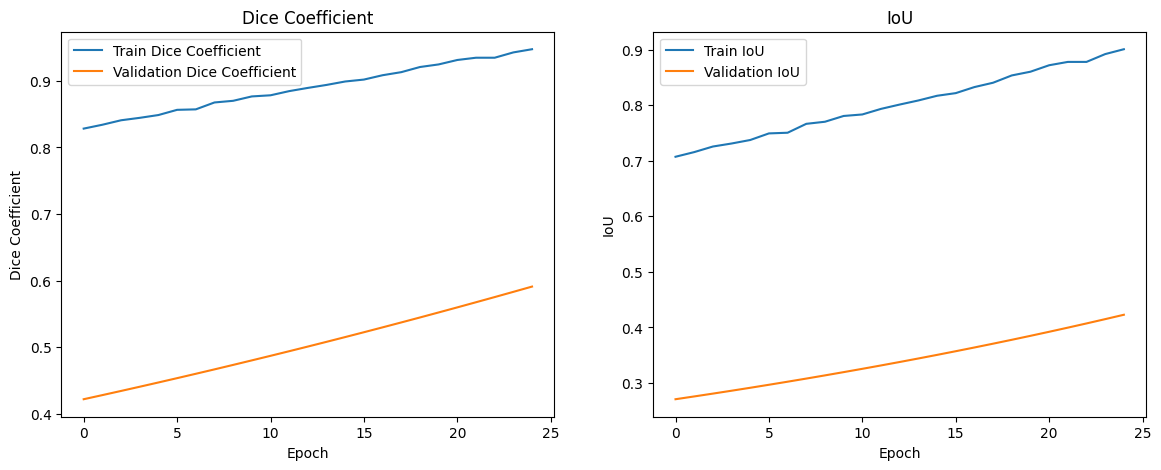

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation Dice coefficient and IoU
plt.figure(figsize=(14, 5))

# Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['DiceCoefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_DiceCoefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['IoU'], label='Train IoU')
plt.plot(history.history['val_IoU'], label='Validation IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()


In [ ]:
input_shape = (None, None, 1)  # Update according to your dataset
# U-Net architecture without batch normalization
def simple_unet_model_4_no_bn(input_shape, num_layers=4, base_filters=64):
    inputs = Input(input_shape)
    x = inputs
    down_layers = []
    for i in range(num_layers):
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        if i < num_layers - 1:
            x = Dropout(0.5)(x)
        down_layers.append(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    for i in range(num_layers - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, down_layers[i]])
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same',kernel_regularizer=l2(1e-4))(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

# Create the model without batch normalization
model_4_layers_no_bn = simple_unet_model_4_no_bn(input_shape, num_layers=2)
model_4_layers_no_bn.compile(optimizer=Adam(learning_rate=0.000001, clipvalue=0.5), loss=tversky_loss, metrics=[DiceCoefficient, IoU])
history = model_4_layers_no_bn.fit(train_images, train_masks, batch_size=8, epochs=5, validation_split=0.1)
layer_4_predicted_no_bn = model_4_layers_no_bn.predict(test_images)
dice_score_no_bn = DiceCoefficient(test_masks, layer_4_predicted_no_bn)
iou_score_no_bn = IoU(test_masks, layer_4_predicted_no_bn)

print(f"U Net Model with 4 Layers (No Batch Normalization) - Dice Score: {dice_score_no_bn}, IoU Score: {iou_score_no_bn}")


Epoch 1/5
9/9 [==============================] - 6s 352ms/step - loss: 0.7174 - DiceCoefficient: 0.3564 - IoU: 0.2171 - val_loss: 1.0509 - val_DiceCoefficient: 0.0225 - val_IoU: 0.0114
Epoch 2/5
9/9 [==============================] - 3s 324ms/step - loss: 0.6361 - DiceCoefficient: 0.4379 - IoU: 0.2808 - val_loss: 1.0383 - val_DiceCoefficient: 0.0348 - val_IoU: 0.0179
Epoch 3/5
9/9 [==============================] - 3s 334ms/step - loss: 0.5446 - DiceCoefficient: 0.5292 - IoU: 0.3604 - val_loss: 1.0176 - val_DiceCoefficient: 0.0551 - val_IoU: 0.0287
Epoch 4/5
9/9 [==============================] - 3s 324ms/step - loss: 0.4384 - DiceCoefficient: 0.6355 - IoU: 0.4668 - val_loss: 0.9829 - val_DiceCoefficient: 0.0891 - val_IoU: 0.0474
Epoch 5/5
1/1 [==============================] - 0s 115ms/step
U Net Model with 4 Layers (No Batch Normalization) - Dice Score: 0.09771673381328583, IoU Score: 0.05192382261157036


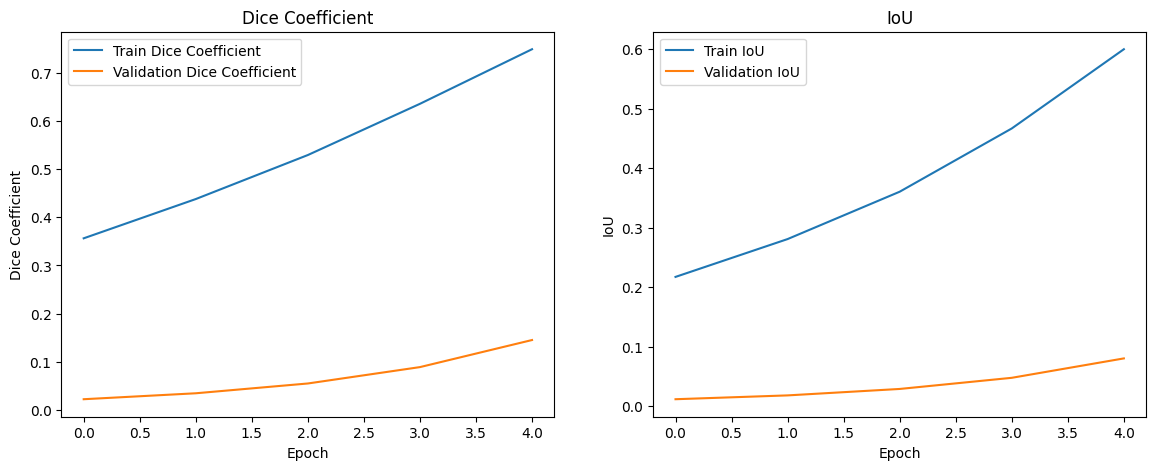

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation Dice coefficient and IoU
plt.figure(figsize=(14, 5))

# Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['DiceCoefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_DiceCoefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['IoU'], label='Train IoU')
plt.plot(history.history['val_IoU'], label='Validation IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()


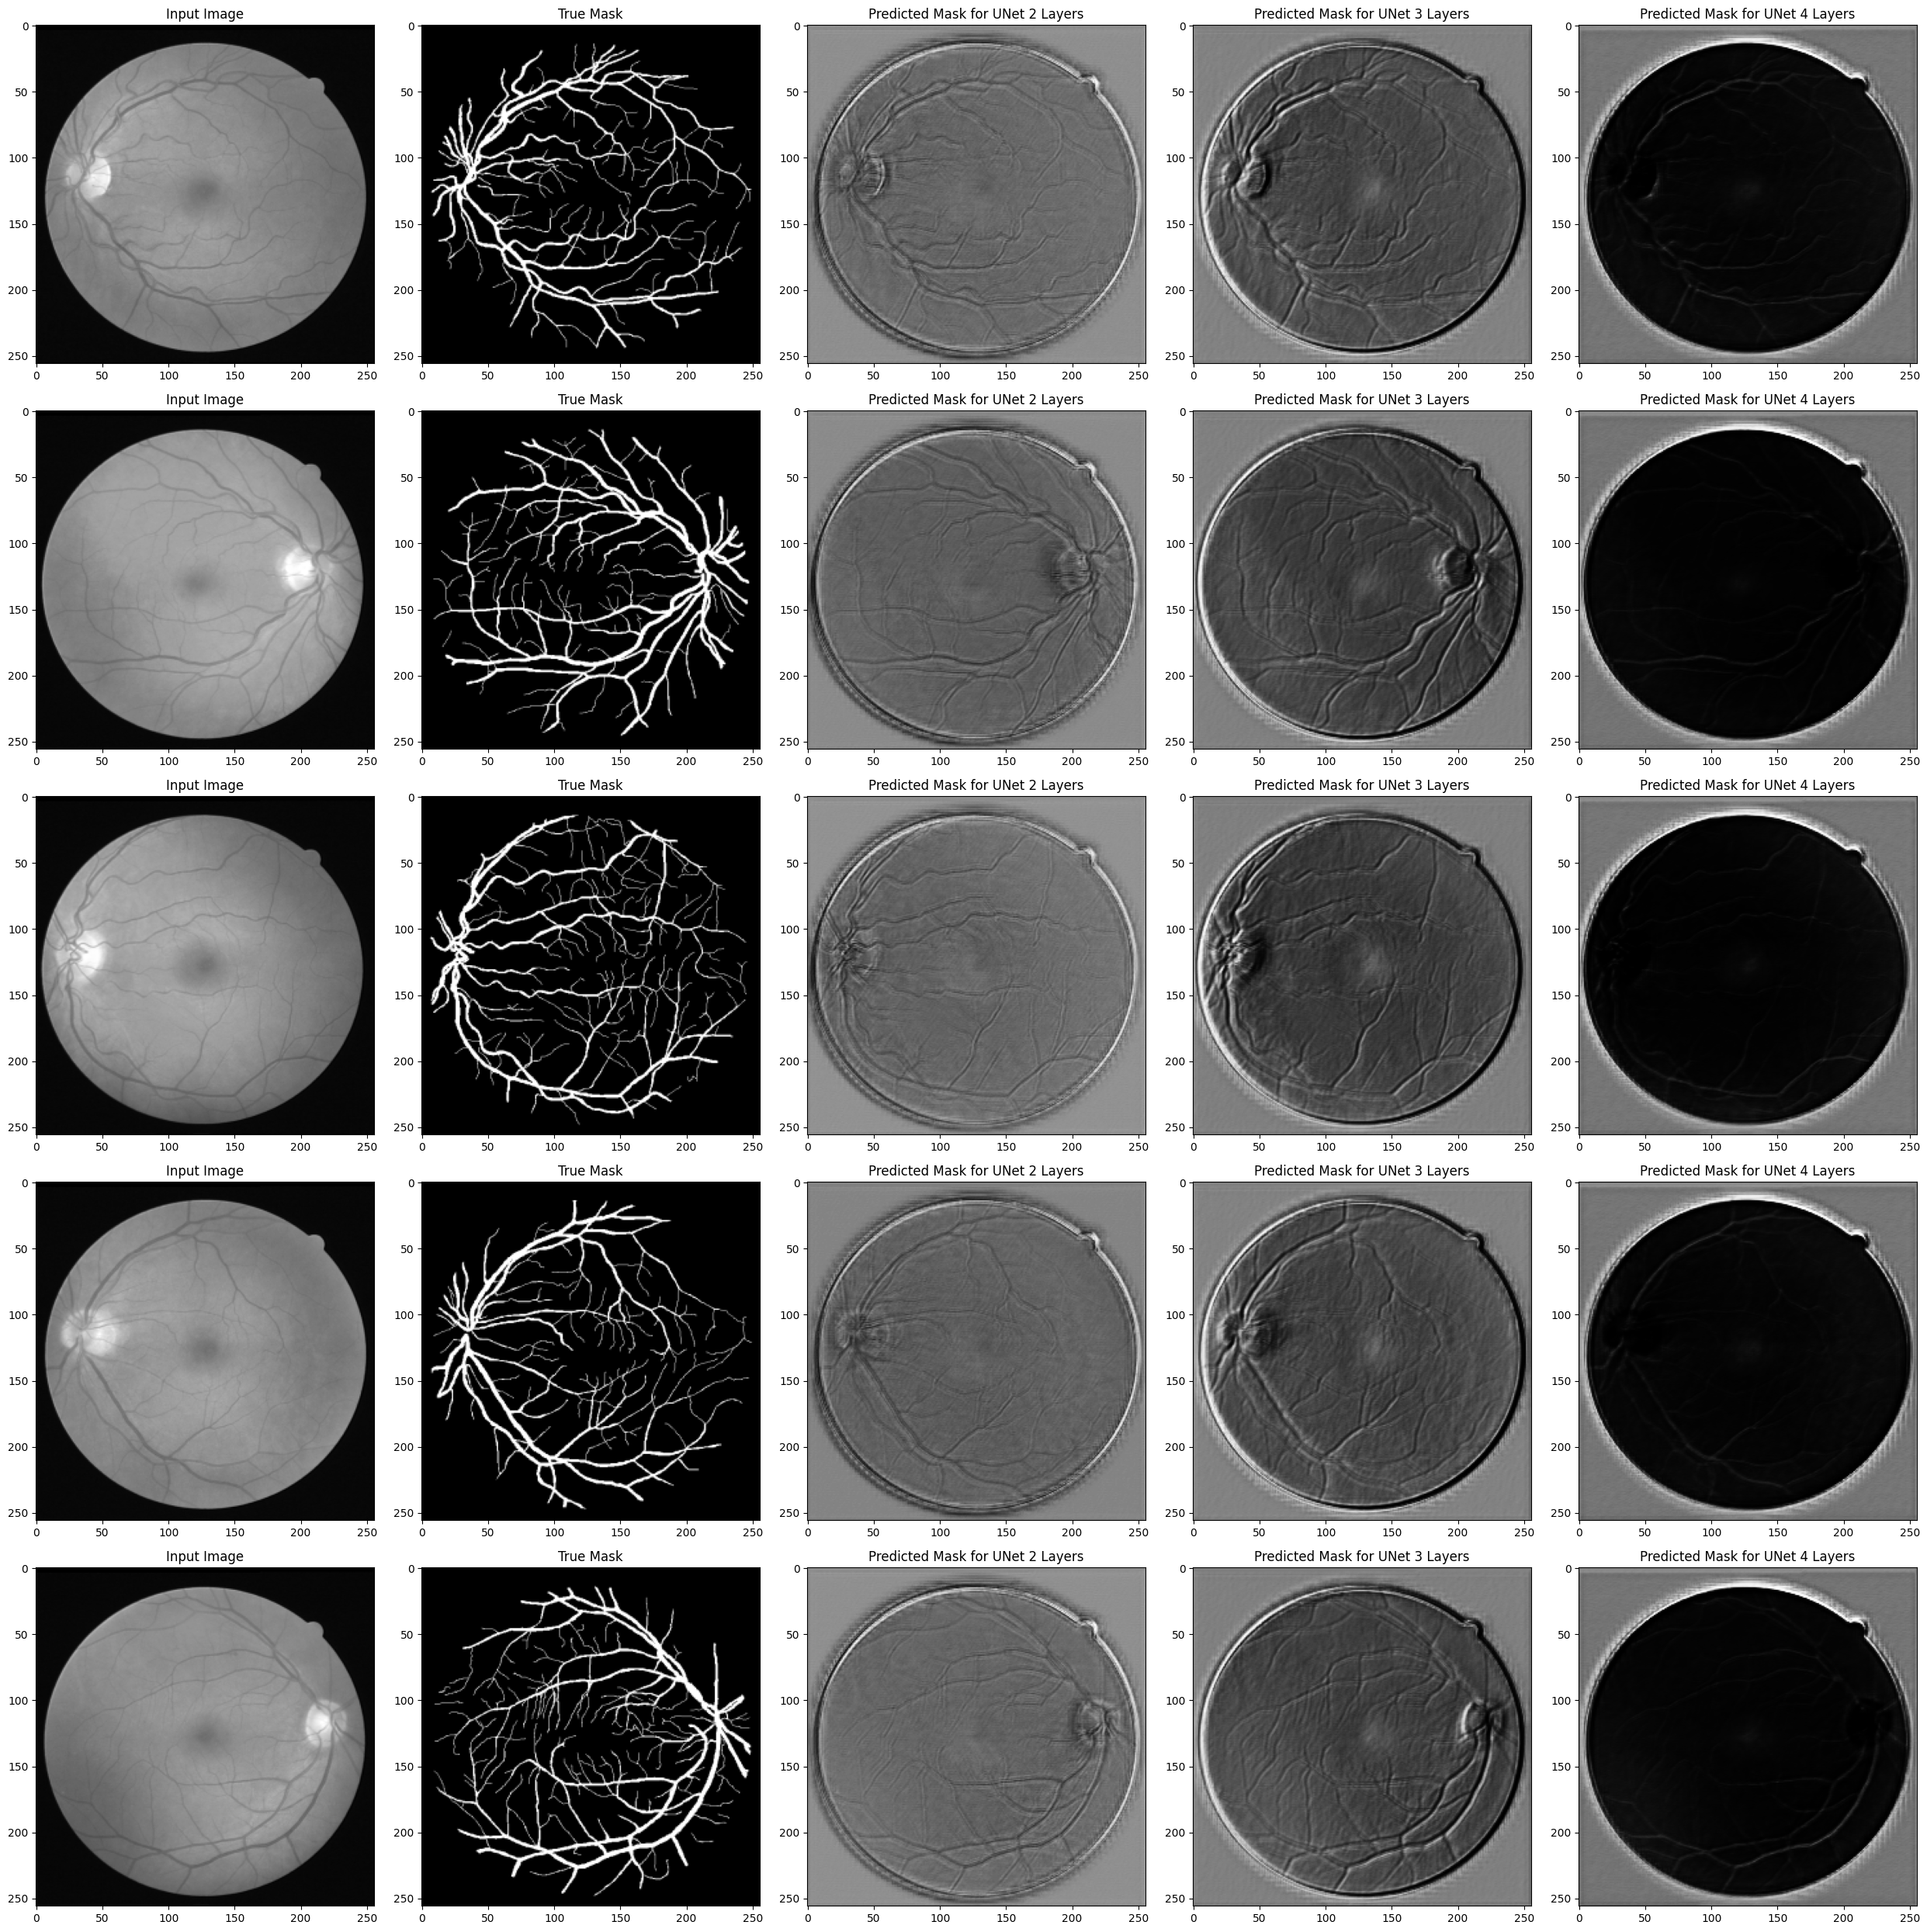

In [ ]:
import matplotlib.pyplot as plt

# Visualization
fig, ax = plt.subplots(5, 5, figsize=(25, 25))
for i in range(5):  # Change the loop range to go from 0 to 5
    ax[i, 0].imshow(test_images[i, ..., 0], cmap="gray")
    ax[i, 1].imshow(test_masks[i, ..., 0], cmap="gray")
    ax[i, 2].imshow(layer_2_predicted_no_bn[i, ..., 0], cmap="gray")
    ax[i, 3].imshow(layer_3_predicted_no_bn[i, ..., 0], cmap="gray")
    ax[i, 4].imshow(layer_4_predicted_no_bn[i, ..., 0], cmap="gray")

    ax[i, 0].set_title("Input Image")
    ax[i, 1].set_title("True Mask")
    ax[i, 2].set_title("Predicted Mask for UNet 2 Layers")
    ax[i, 3].set_title("Predicted Mask for UNet 3 Layers")
    ax[i, 4].set_title("Predicted Mask for UNet 4 Layers")

plt.tight_layout()
plt.show()
